## Merchantよってamountの絶対値あたりの価値は違うという仮説で、特徴をMain Stateあたりのリフトにする

In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features
import datetime

from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
from sklearn.metrics import mean_squared_error

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

### Data Load

In [40]:
hist = utils.read_df_pkl('../input/hist_clean*0*')
new = utils.read_df_pkl('../input/new_clean*0*')
df = pd.concat([hist, new], axis=0)

### Subsector_id

In [41]:
#========================================================================
# subsector_id

df['cnt'] = 1
df_subsector = df.groupby([key, 'subsector_id'])['cnt'].sum().reset_index()
df_rec = df.groupby([key])['cnt'].sum().reset_index()

main = df_subsector.merge(df_rec, how='inner', on=key)
del df_subsector, df_rec
gc.collect()

df['authorized_flag'] = df['authorized_flag'].map(lambda x: 0 if x=='N' else 1)
auth_mean = df.groupby('subsector_id')['authorized_flag'].mean()

main['main_subsector_ratio'] = main['cnt_x'] / (main['cnt_y'])
main_subsector_idx = main.groupby(key)['main_subsector_ratio'].idxmax()

main_subsector = main.iloc[main_subsector_idx][[key, 'subsector_id', 'main_subsector_ratio']]
main_subsector['main_subsector_auth_mean'] = main_subsector['subsector_id'].map(auth_mean)
print(main_subsector.shape)
main_subsector.head()
main_subsector.rename(columns={'subsector_id':'main_subsector_id'}, inplace=True)
#========================================================================

(325540, 4)


In [42]:
# N数が少ないSubsectorは-99とする
main_subsec_dict = main_subsector['main_subsector_id'].value_counts().to_dict()
train_test['N_main_subsector'] = train_test['main_subsector_id'].map(main_subsec_dict)
train_test['N_subsector_id'] = train_test['main_subsector_id'].where(train_test['N_main_subsector']>5000, -99)
train_test['N_subsector_id'].value_counts()

 33    96982
 37    59656
 19    42782
 29    30890
 27    24012
-99    20645
 34    16351
 8     11406
 16    10016
 21     6969
 15     5831
Name: N_subsector_id, dtype: int64

In [54]:
#========================================================================
# Subsector Ratio
#========================================================================
# サンプル数を考慮したidに基づいて、ratioを計算する
feat_sub_list = list(train_test.set_index('main_subsector_id')['N_subsector_id'].to_dict().keys())
feat_sub_list.remove(-99)

df['N_subsector_id'] = df['subsector_id'].map(lambda x: x if x in feat_sub_list else -99)
df['cnt'] = 1
df_subsector = df.groupby([key, 'N_subsector_id'])['cnt'].sum().reset_index()
df_rec = df.groupby([key])['cnt'].sum().reset_index()

df_ratio = df_subsector.merge(df_rec, how='inner', on=key)
del df_subsector, df_rec
gc.collect()

df['authorized_flag'] = df['authorized_flag'].map(lambda x: 0 if x=='N' else 1)
auth_mean = df.groupby('N_subsector_id')['authorized_flag'].mean()

df_ratio['N_subsector_ratio'] = df_ratio['cnt_x'] / (df_ratio['cnt_y'])

# subsector_ratioを横持ちにしてfeatureにする
ratio_yoko = df_ratio.pivot_table(index=key, columns='N_subsector_id', values='N_subsector_ratio').fillna(0)
ratio_yoko.columns = [f"N_subsector_id_{col}_ratio" for col in ratio_yoko.columns]
base = utils.read_df_pkl('../input/base_first*0*').set_index(key)
ratio_yoko = base.join(ratio_yoko)
ratio_yoko.head()

100%|██████████| 3/3 [00:00<00:00, 28.26it/s]


,first_active_month,target,N_subsector_id_-99_ratio,N_subsector_id_8_ratio,N_subsector_id_15_ratio,N_subsector_id_16_ratio,N_subsector_id_19_ratio,N_subsector_id_21_ratio,N_subsector_id_27_ratio,N_subsector_id_29_ratio,N_subsector_id_33_ratio,N_subsector_id_34_ratio,N_subsector_id_37_ratio
card_id,,,,,,,,,,,,,
C_ID_92a2005557,2017-06,-0.820283,0.226148,0.017668,0.000000,0.038869,0.017668,0.007067,0.035336,0.031802,0.031802,0.346290,0.247350
C_ID_3d0044924f,2017-01,0.392913,0.179775,0.000000,0.005618,0.075843,0.157303,0.008427,0.081461,0.078652,0.033708,0.207865,0.171348
C_ID_d639edf6cd,2016-08,0.688056,0.113636,0.000000,0.000000,0.068182,0.000000,0.000000,0.000000,0.000000,0.727273,0.000000,0.090909
C_ID_186d6a6901,2017-09,0.142495,0.166667,0.011905,0.023810,0.035714,0.000000,0.000000,0.166667,0.154762,0.011905,0.107143,0.321429
C_ID_cdbd2c0db2,2017-11,-0.159749,0.177515,0.000000,0.000000,0.005917,0.023669,0.000000,0.065089,0.071006,0.053254,0.035503,0.568047


In [53]:
#========================================================================
# Save Feature
prefix = '217_msb'
df_feat = ratio_yoko
# for col in ['N_main_subsector']:
# for col in ['TE_main_subsector']:
print(df_feat.shape)
for col in df_feat.columns:
    feature = df_feat[col].values.astype('float32')
    utils.to_pkl_gzip(obj=feature, path=f'../features/1_first_valid/{prefix}_{col}')
#========================================================================

(325540, 11)


(325540,)


In [7]:
main_subsector.set_index(key, inplace=True)

df_train = utils.read_df_pkl('../input/train0*')
df_test = utils.read_df_pkl('../input/test0*')
df_train.set_index(key, inplace=True)
df_test.set_index(key, inplace=True)
train_test = pd.concat([df_train, df_test], axis=0)

train_test = train_test.join(main_subsector['main_subsector_id'])
# subsector -1 (net?)の割合

100%|██████████| 3/3 [00:00<00:00, 144.15it/s]


,feature_1,feature_2,feature_3,first_active_month,target,main_subsector_id,subsector-1_ratio
card_id,,,,,,,
C_ID_92a2005557,5,2,1,2017-06,-0.820283,34,NaN
C_ID_3d0044924f,4,1,0,2017-01,0.392913,34,NaN
C_ID_d639edf6cd,2,2,0,2016-08,0.688056,33,NaN
C_ID_186d6a6901,4,3,0,2017-09,0.142495,37,NaN
C_ID_cdbd2c0db2,1,3,0,2017-11,-0.159749,37,NaN


In [37]:
#========================================================================
# Target Encoding
#========================================================================
from sklearn.model_selection import StratifiedKFold, KFold

te_level = 'N_subsector_id'

seed = 1208
train = train_test[~train_test[target].isnull()]
test = train_test[train_test[target].isnull()].reset_index()

train['rounded_target'] = train['target'].round(0)
train = train.sort_values('rounded_target').reset_index()
vc = train['rounded_target'].value_counts()
vc = dict(sorted(vc.items()))
df = pd.DataFrame()
train['indexcol'],idx = 0,1
for k,v in vc.items():
    step = train.shape[0]/v
    indent = train.shape[0]/(v+1)
    df2 = train[train['rounded_target'] == k].sample(v, random_state=120).reset_index(drop=True)
    for j in range(0, v):
        df2.at[j, 'indexcol'] = indent + j*step + 0.000001*idx
    df = pd.concat([df2,df])
    idx+=1
train = df.sort_values('indexcol', ascending=True).reset_index(drop=True)
del train['indexcol'], train['rounded_target']
fold_type = 'self'
fold = 6
folds = KFold(n_splits=fold, shuffle=False, random_state=seed)
kfold = list(folds.split(train, train[target].values))

val_list = []
for n_fold, (trn_idx, val_idx) in enumerate(kfold):
    x_train = train[[te_level, target]].loc[trn_idx, :]
    x_val = train[[key, te_level]].loc[val_idx]
    
    TE_map = x_train.groupby(te_level)[target].mean()
    x_val['TE_main_subsector'] = x_val[te_level].map(TE_map)
    val_list.append(x_val.copy())
else:
    TE_map = train.groupby(te_level)[target].mean()
    test['TE_main_subsector'] = test[te_level].map(TE_map)
    val_list.append(test)
    
df_te = pd.concat(val_list, axis=0)[[key, 'TE_main_subsector']].set_index(key)['TE_main_subsector']
base = utils.read_df_pkl('../input/base_first*0*').set_index(key)
df_te = base.join(df_te)
df_te.head(10)

100%|██████████| 3/3 [00:00<00:00, 58.23it/s]


,first_active_month,target,TE_main_subsector
card_id,,,
C_ID_92a2005557,2017-06,-0.820283,-0.371159
C_ID_3d0044924f,2017-01,0.392913,-0.350777
C_ID_d639edf6cd,2016-08,0.688056,-0.366989
C_ID_186d6a6901,2017-09,0.142495,-0.349840
C_ID_cdbd2c0db2,2017-11,-0.159749,-0.360823
C_ID_0894217f2f,2016-09,0.871585,-0.347058
C_ID_7e63323c00,2016-12,0.230129,-0.367646
C_ID_dfa21fc124,2017-09,2.135850,-0.367646
C_ID_fe0fdac8ea,2017-08,-0.065406,-0.362943


In [38]:
#========================================================================
# Save Feature
prefix = '217_msb'
df_feat = df_te
# for col in ['N_main_subsector']:
for col in ['TE_main_subsector']:
    feature = df_feat[col].values.astype('float32')
    print(feature.shape)
    if col=='out_ratio':
        col = 'state_' + col
    utils.to_pkl_gzip(obj=feature, path=f'../features/1_first_valid/{prefix}_{col}')
#========================================================================

(325540,)


### Visualize

33: 60194


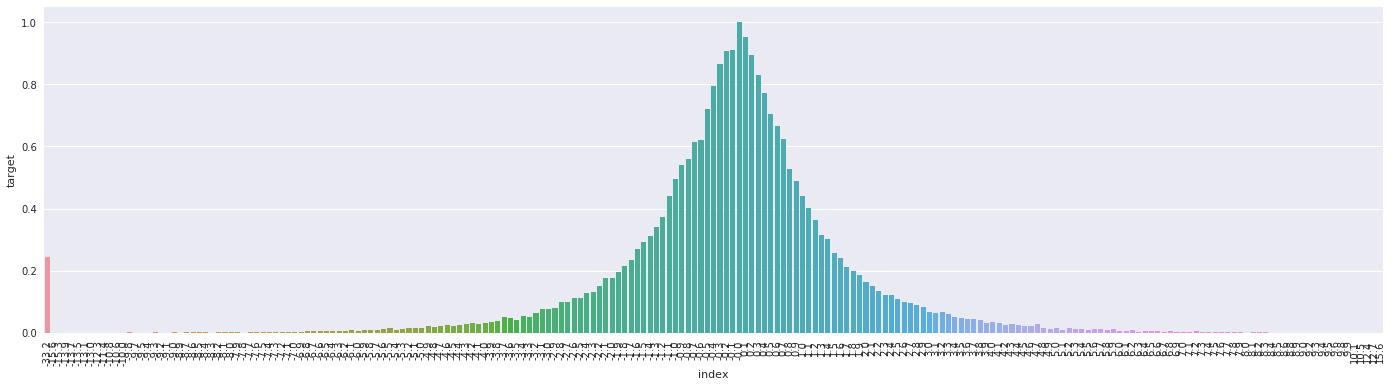

37: 36893


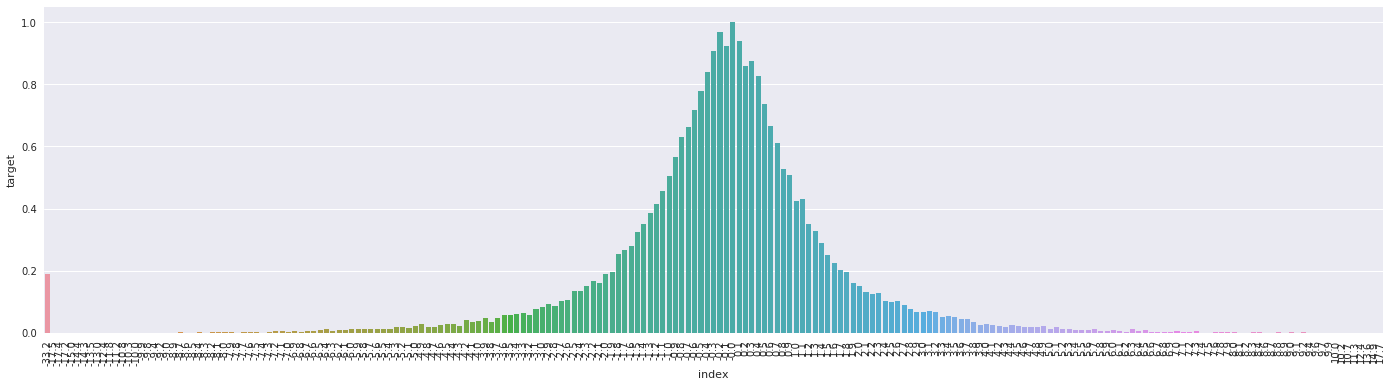

19: 26512


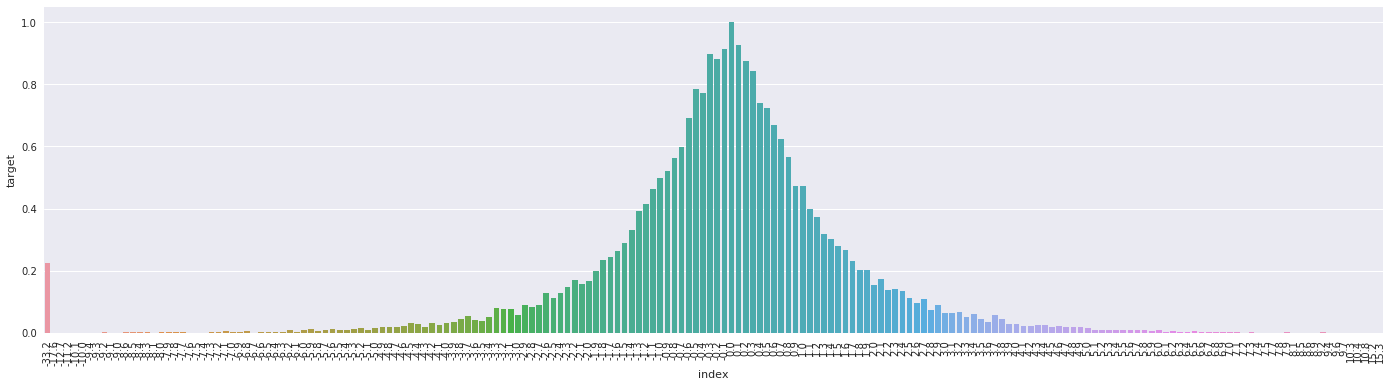

29: 19328


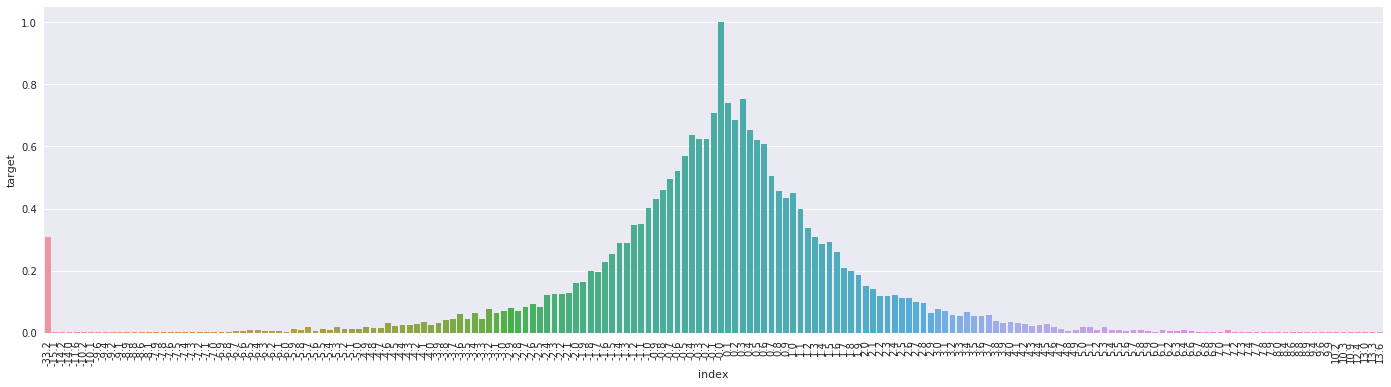

27: 14909


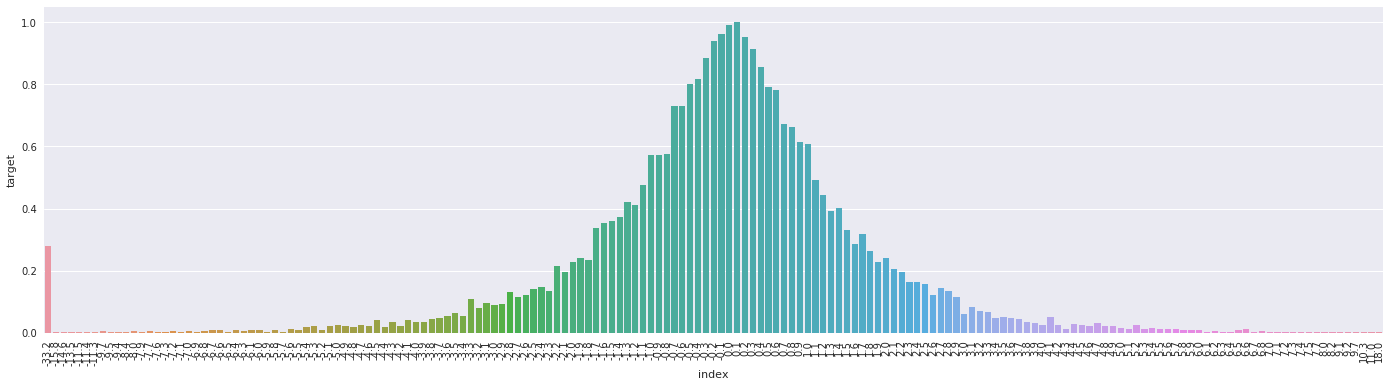

34: 10222


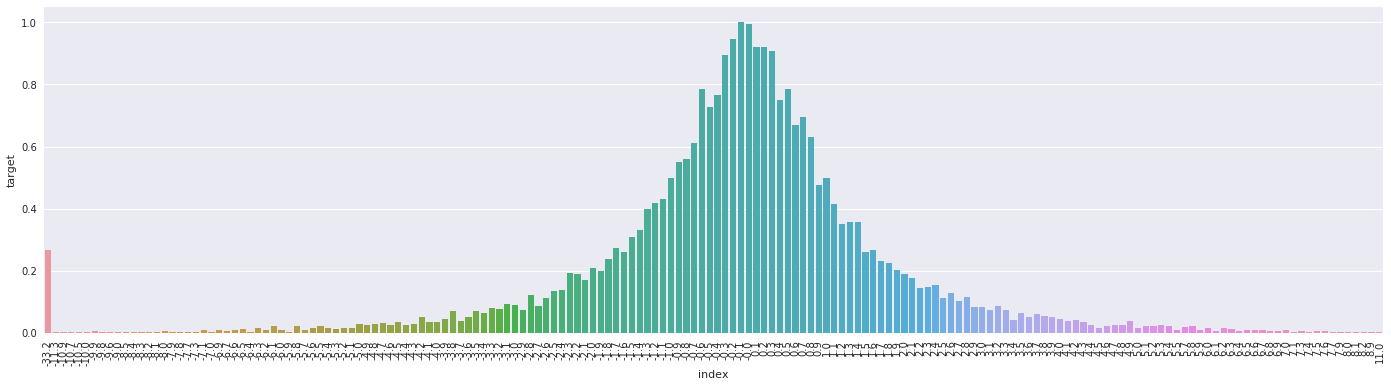

8: 7050


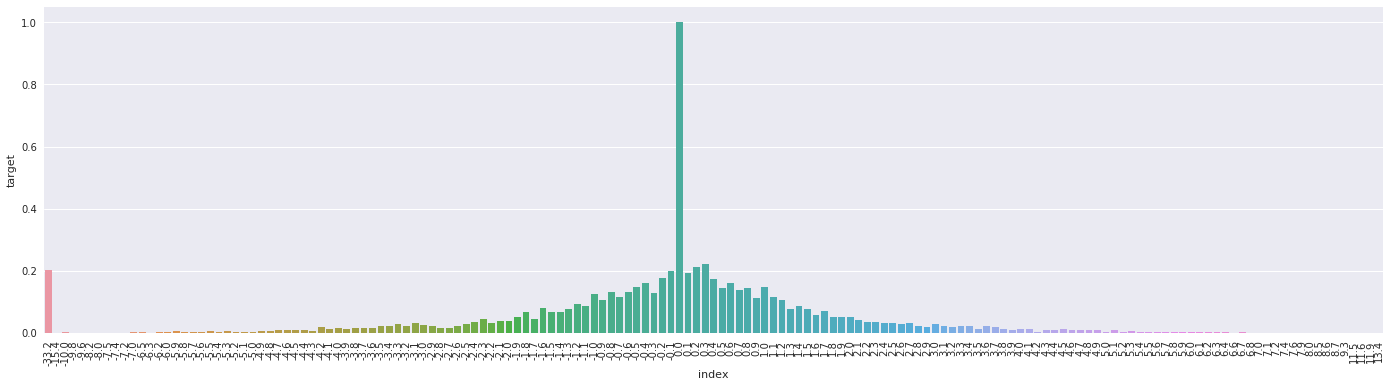

16: 6106


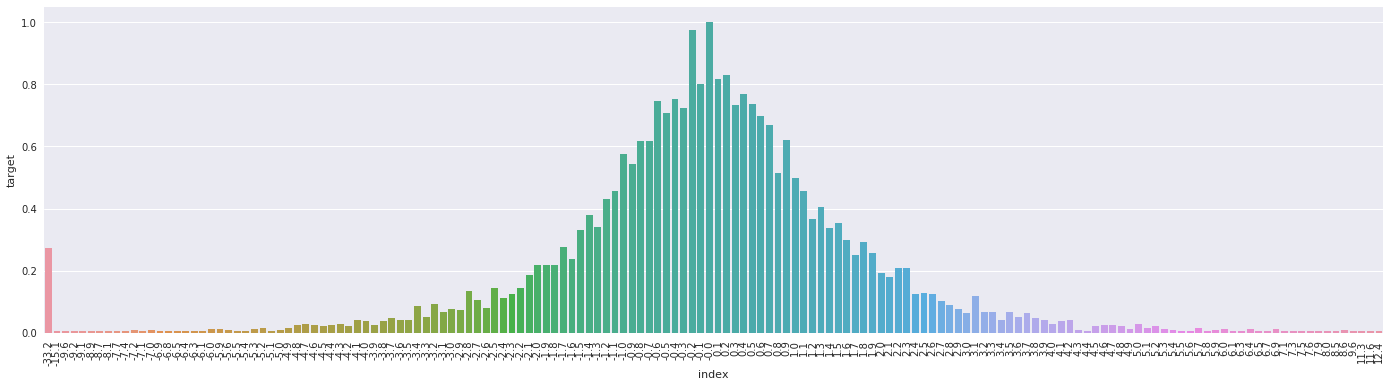

21: 4314


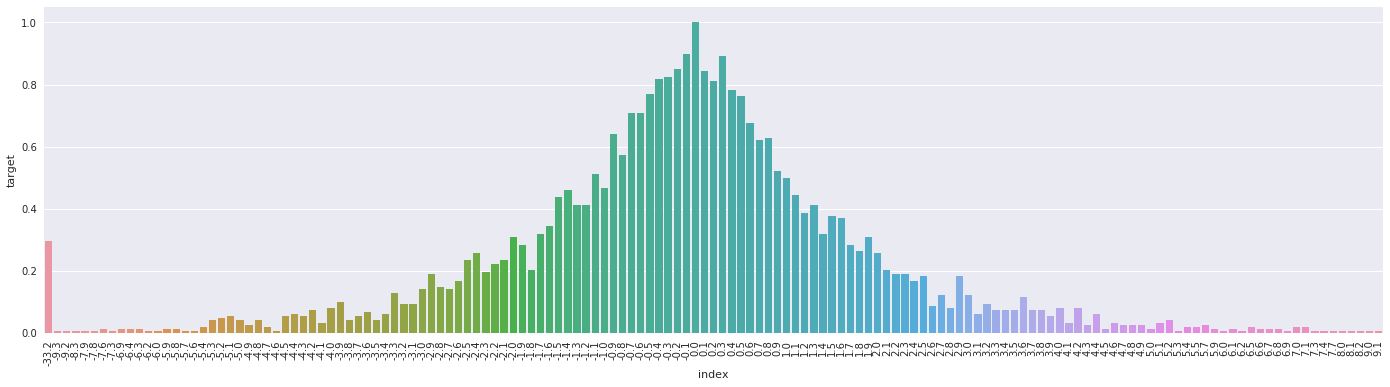

15: 3652


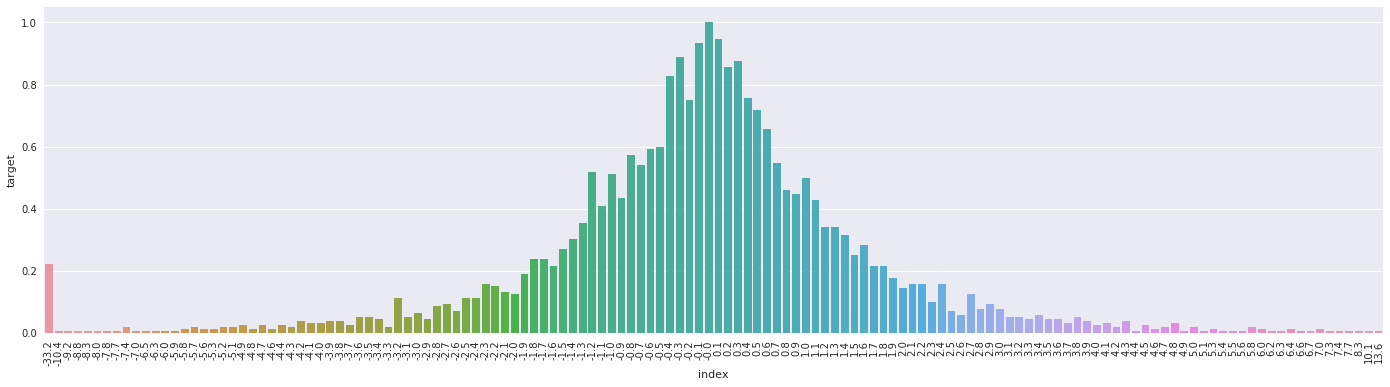

1: 2488


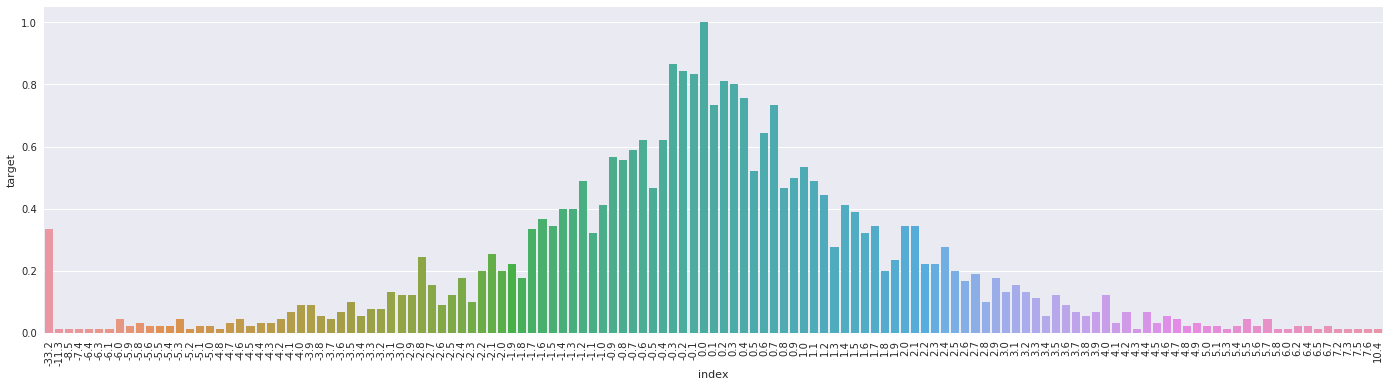

7: 1814


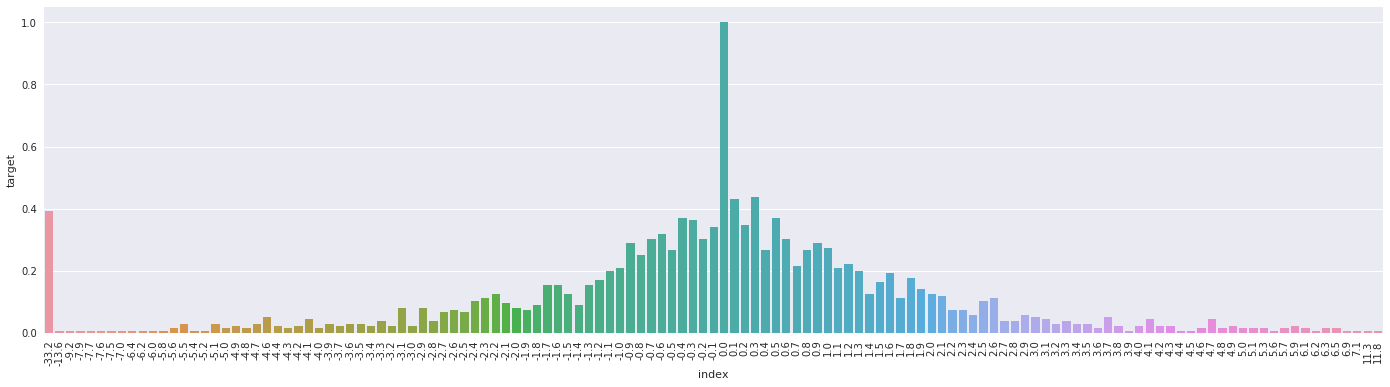

18: 1729


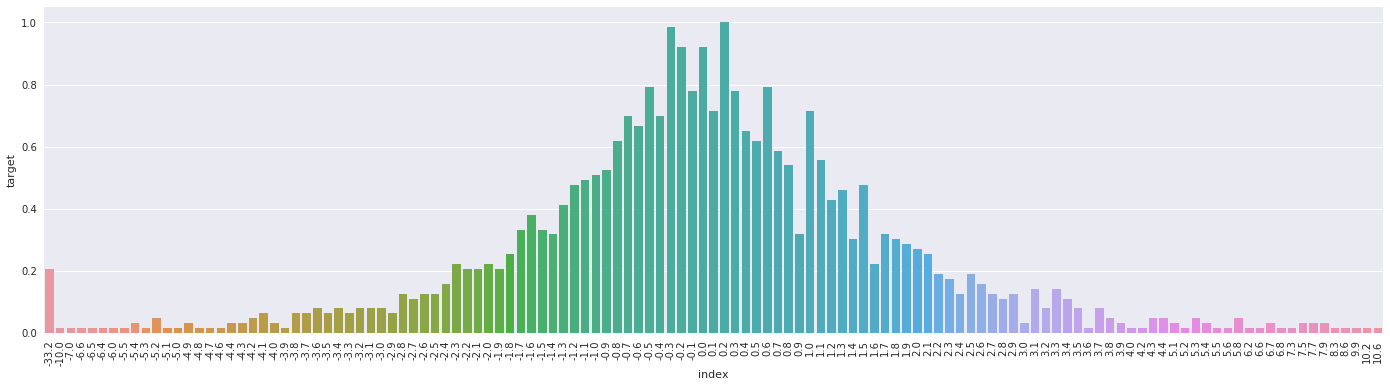

22: 1236


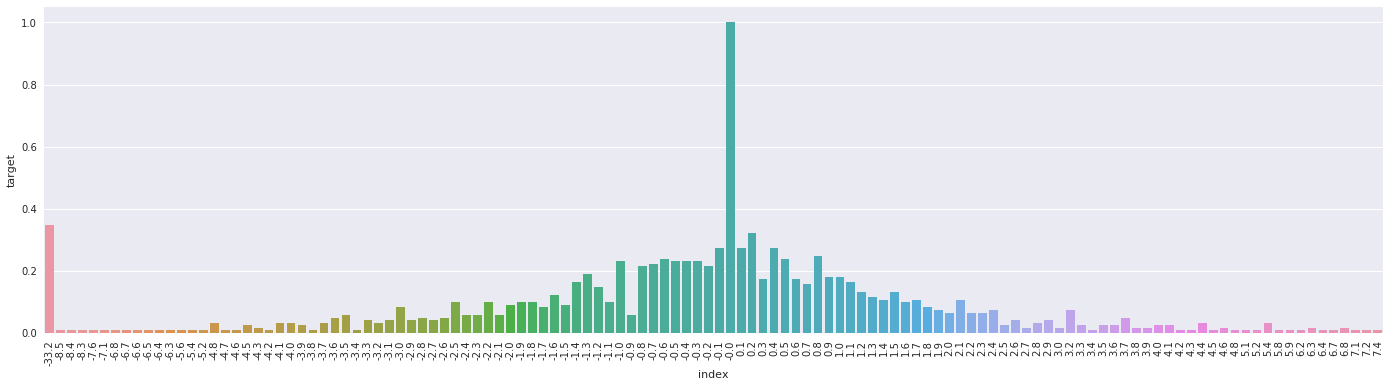

20: 551


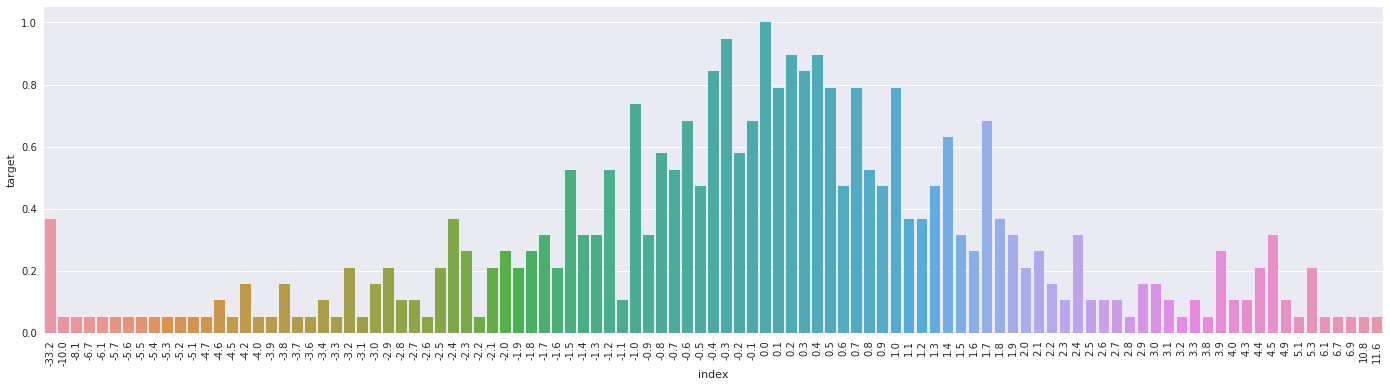

3: 550


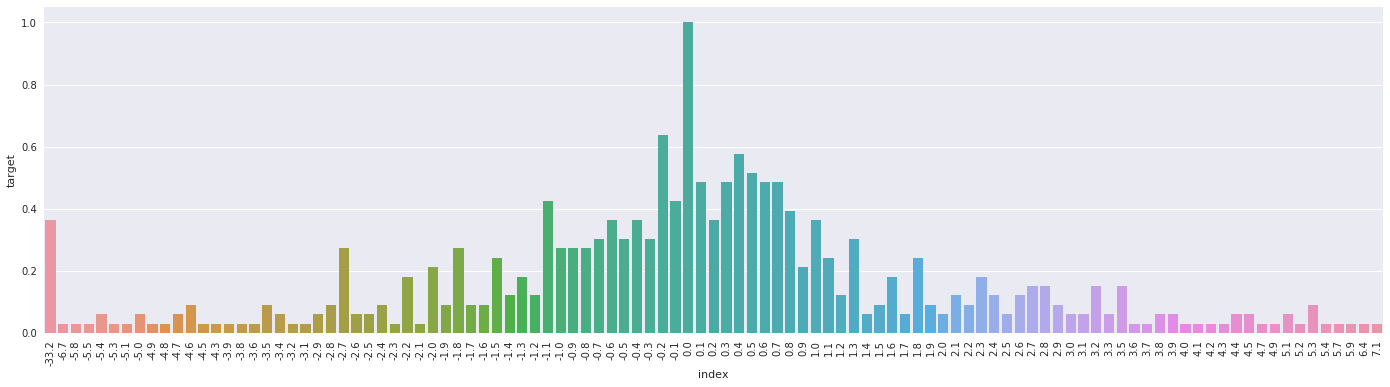

25: 534


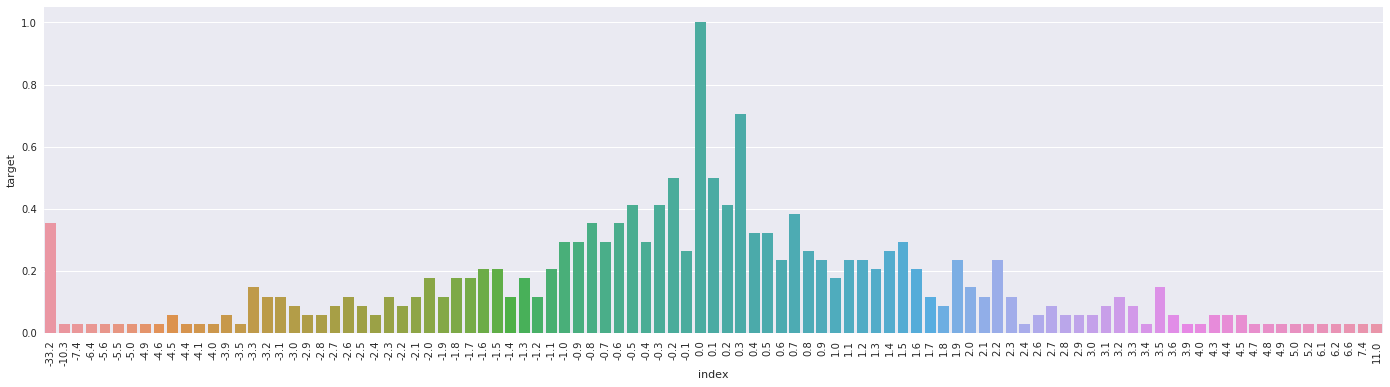

17: 470


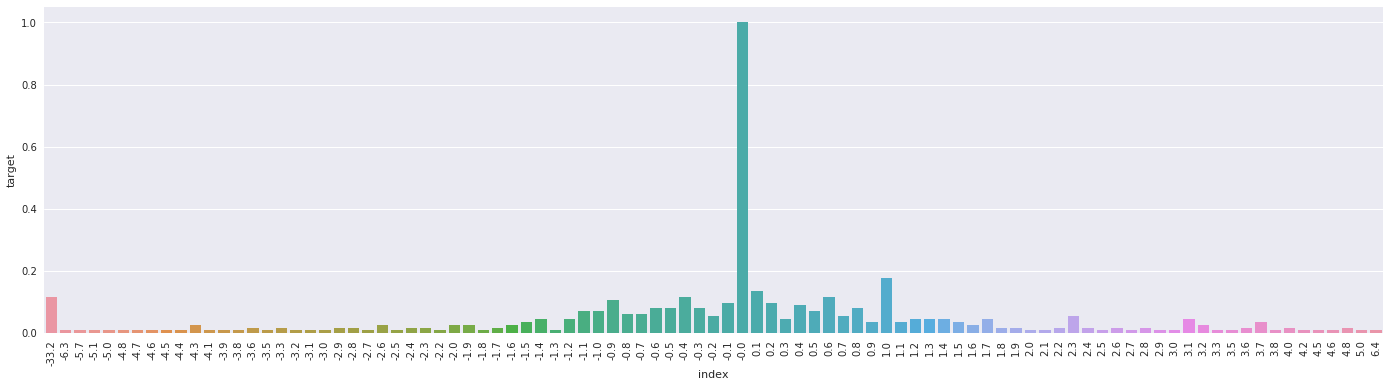

36: 455


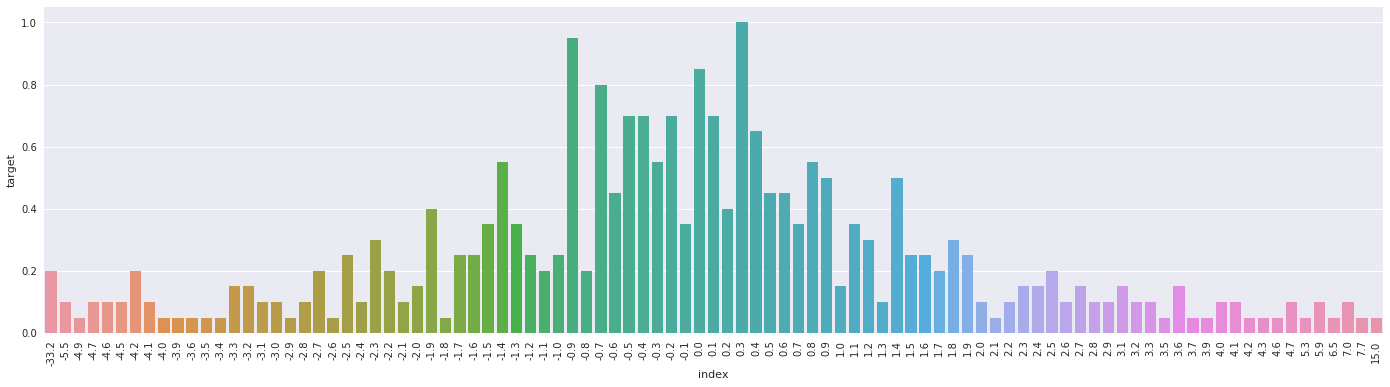

30: 402


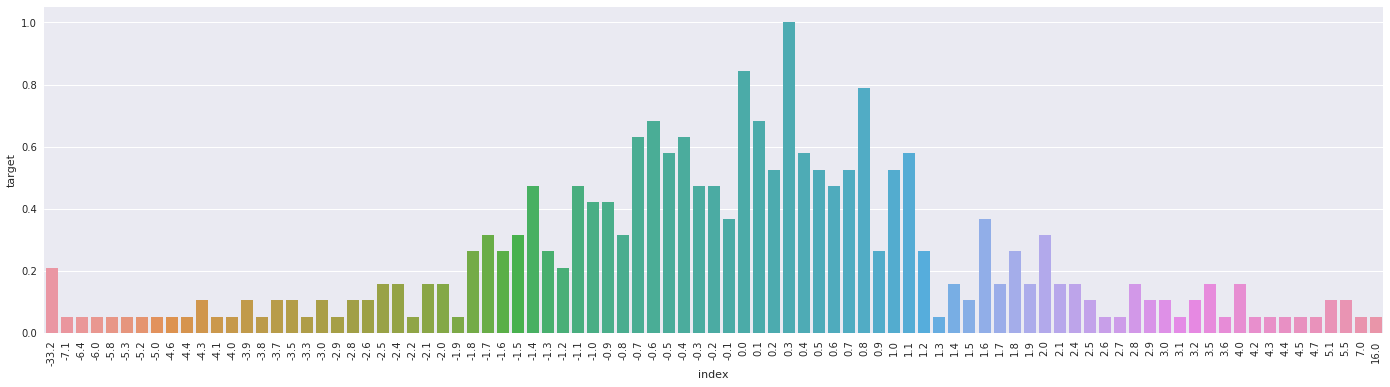

31: 333


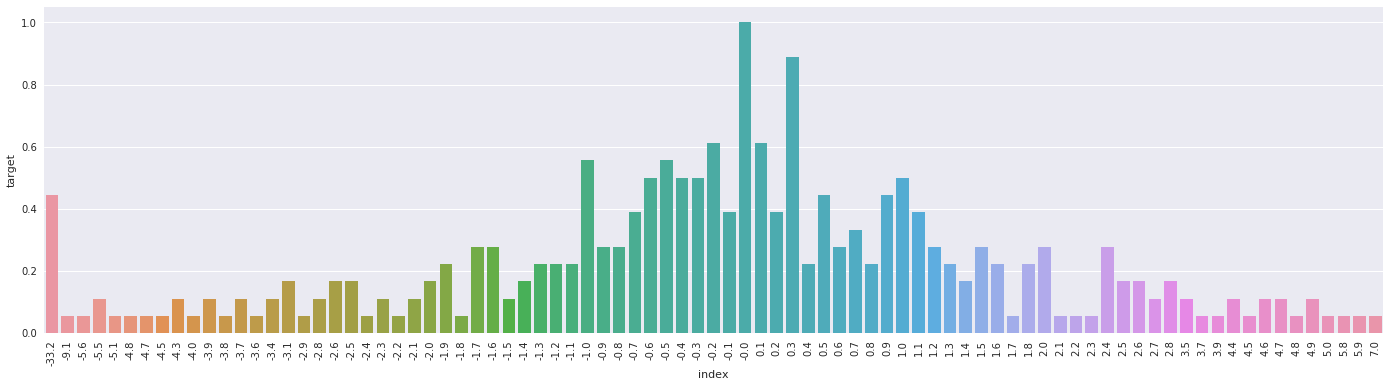

39: 256


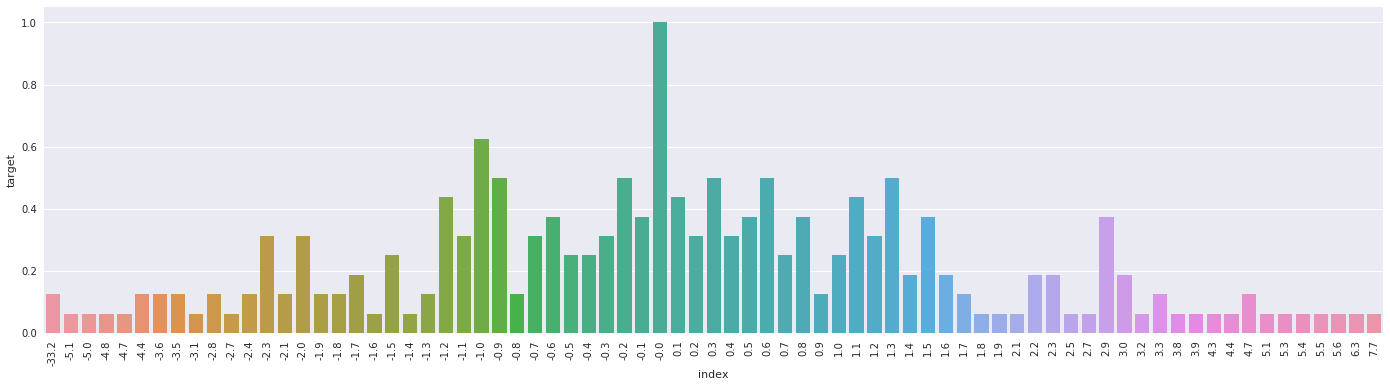

9: 251


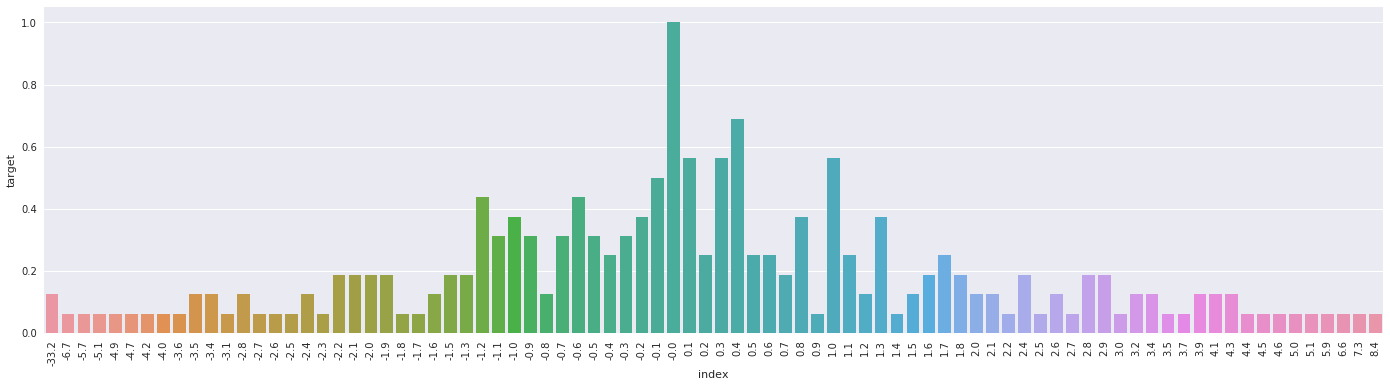

2: 228


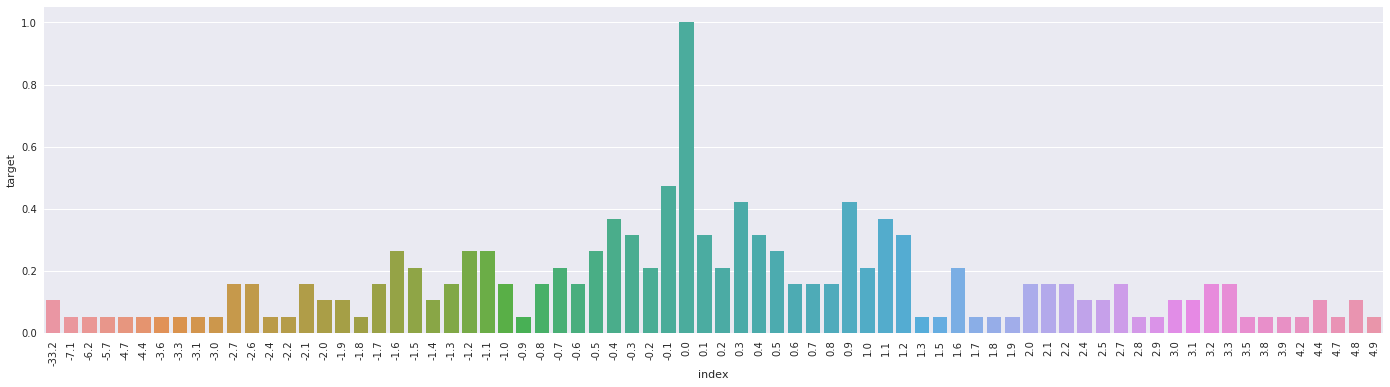

10: 204


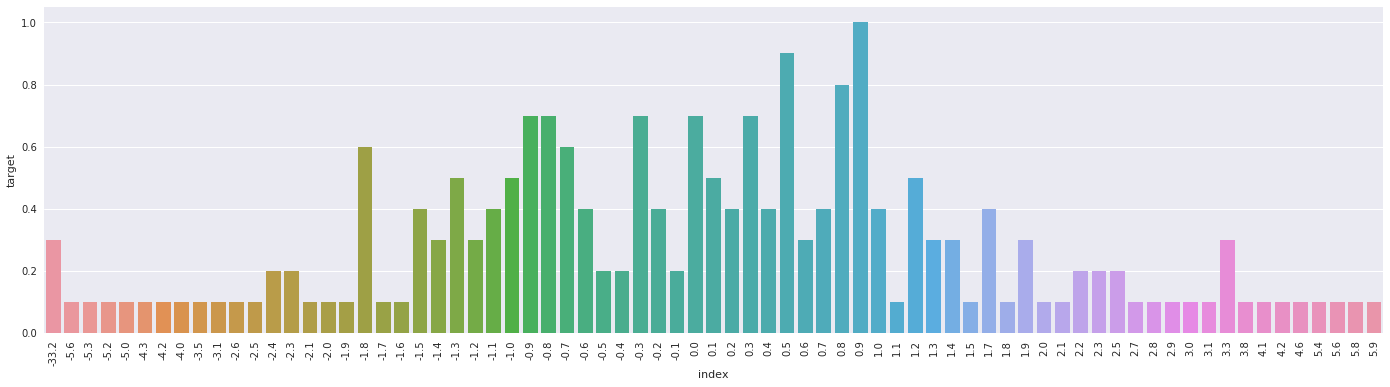

12: 197


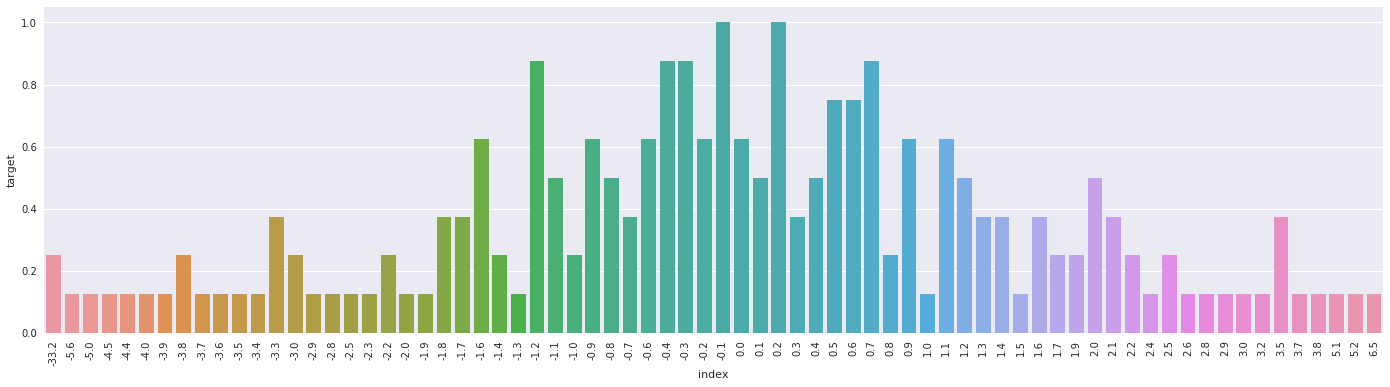

32: 170


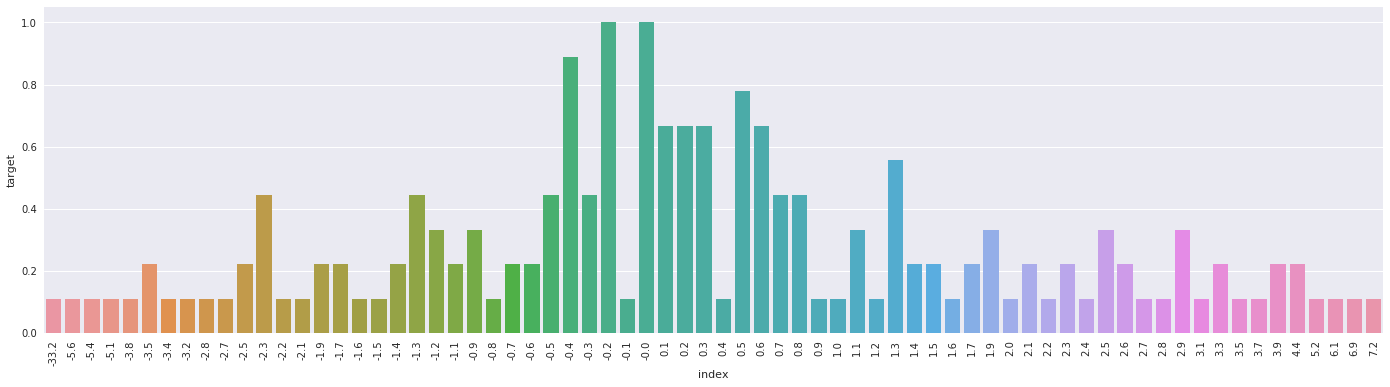

41: 153


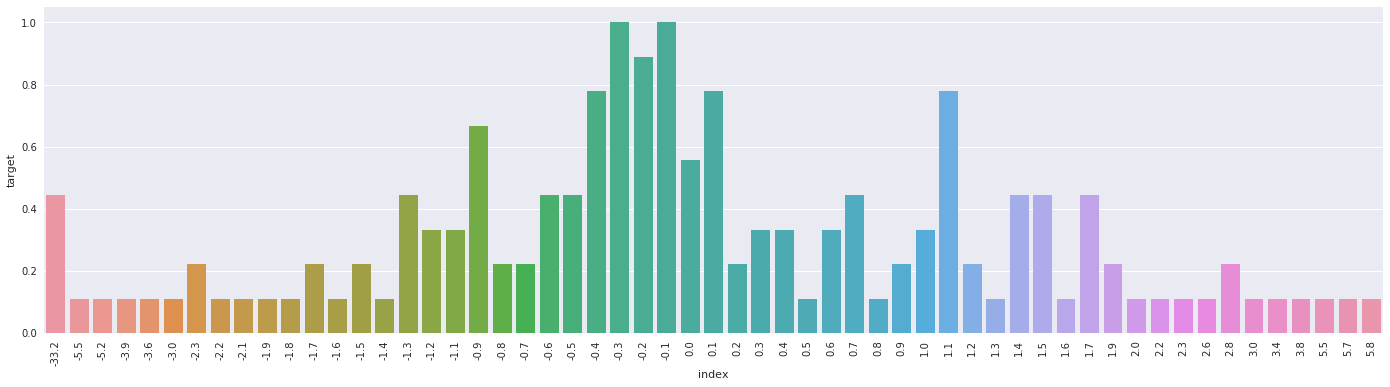

4: 155


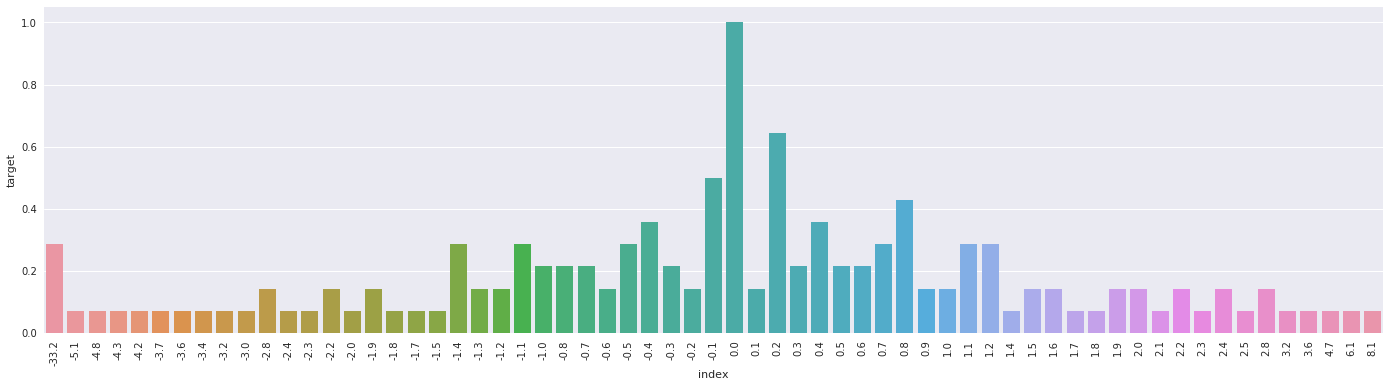

26: 114


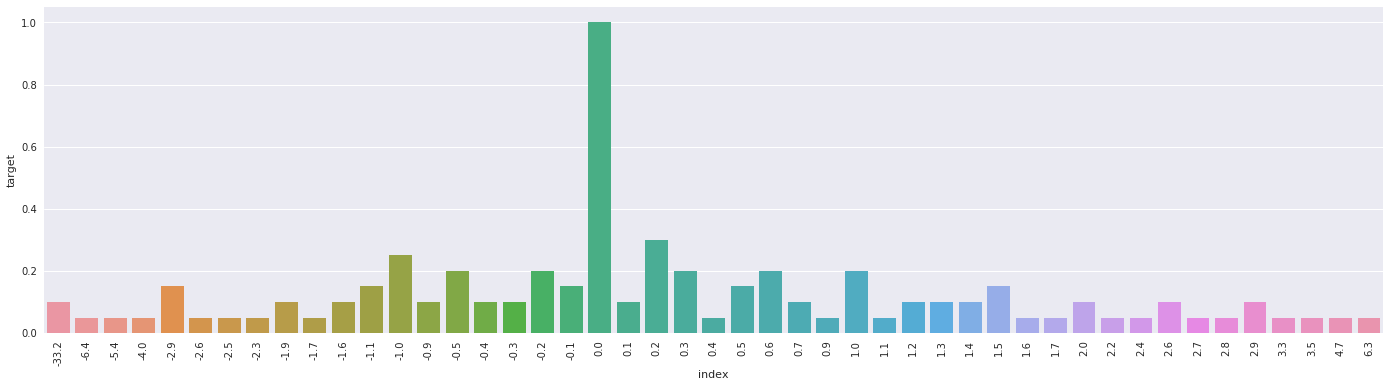

5: 116


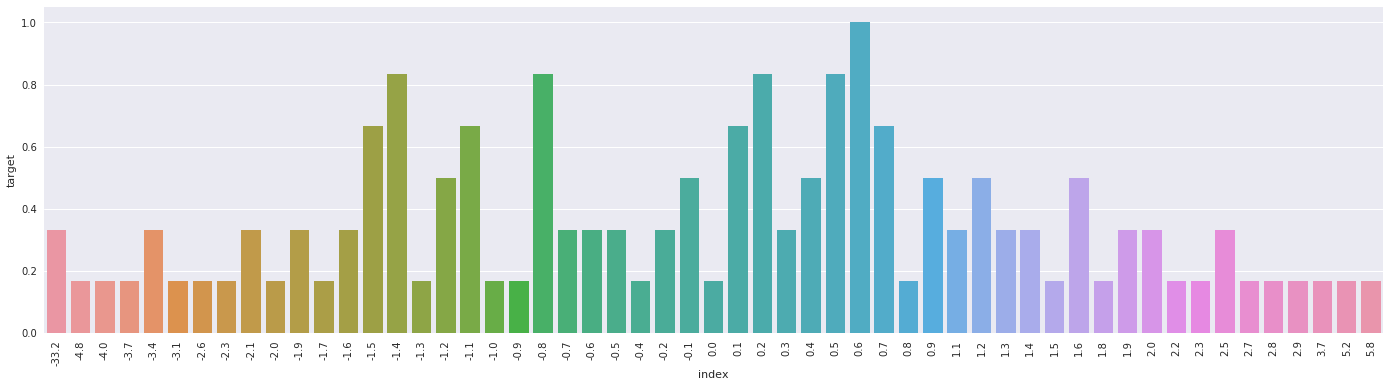

14: 91


IndexError: index 0 is out of bounds for axis 0 with size 0

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# viz_col = 'CLV'

main_subsector_list = list(main_subsector['main_subsector_id'].value_counts().index)
df_train = train_test[~train_test[target].isnull()]
df = df_train

for i in main_subsector_list:
    tmp = df[df['main_subsector_id']==i]
    
    print(f"{i}: {len(tmp)}")
    
#========================================================================
    # Main subsectorにおけるOutlierの割合をとる
    tmp[target] = tmp[target].map(lambda x: np.round(x, 1))
    tmp = tmp[target].value_counts().reset_index()
    max_target = tmp[target].max()
    tmp[target] /= max_target
    out_ratio = tmp[tmp['index']<-30][target].values[0]
    train_test.loc[train_test['main_subsector_id']==i, 'out_ratio'] = out_ratio
#========================================================================
    plt.figure(figsize=(24, 6))
#     sns.distplot(a=tmp[viz_col])
    sns.barplot(data=tmp, x='index', y=target)
    plt.xticks(rotation=90)
    plt.show()

In [53]:
#========================================================================
# Main State Ratio, Main State Out Ratio
prefix = '216_mst'
# for col in ['out_ratio', 'main_state_id']:
for col in ['state-1_ratio']:
    feature = train_test[col].values.astype('float32')
    if col=='out_ratio':
        col = 'state_' + col
    utils.to_pkl_gzip(obj=feature, path=f'../features/1_first_valid/{prefix}_{col}')
#========================================================================